# DCNet 
Deconvolution network (DCNet), an "explainable" artificial neural network model was created to infer cell content from bulk RNA-Seq samples. It embeds the relationship between 434 cells and 9078 marker genes in a neural network,and uses a hidden layer to characterize the cell type and content.
  

# Publication
  Wang, X., Wang, H., Liu, D., Wang, N., He, D., Wu, Z., Zhu, X., Wen, X., Li, X., Li, J., & Wang, Z. (2022). Deep learning using bulk RNA-seq data expands cell landscape identification in tumor microenvironment. Oncoimmunology, 11(1), 2043662. https://doi.org/10.1080/2162402X.2022.2043662
  

In [1]:
from DCNet.models import DCNetNoise
from mxnet import nd
import pickle

In [2]:
# data path
net_params = 'net_M434_adam_T600_DCNetBnoise-D1.params'
relation_dir = 'relation_matrix.pkl'
net_index_dir = 'index.pkl'
demo_data_dir = 'demo_data.pkl'

## 1.load data

In [3]:
with open(relation_dir, 'rb') as f:
    relation_data = pickle.load(f)
with open(net_index_dir, 'rb') as f:
    net_index = pickle.load(f)
with open(demo_data_dir, 'rb') as f:
    demo_data = pickle.load(f)
ix, ox = net_index['input_ix'], net_index['output_ix'] 
input_data, output_data = demo_data['input_data'], demo_data['output_data']

In [4]:
relation_data.iloc[:3,:5]

cellName,1-cell stage cell (Blastomere),4-cell stage cell (Blastomere),8-cell stage cell (Blastomere),AXL+SIGLEC6+ dendritic cell,Abnormal plasma cell
SUSD3,0,0,0,0,0
PTPRU,0,0,0,0,0
EPB41L5,0,0,0,0,0


In [5]:
input_data.shape, output_data.shape

((9078, 300), (21136, 300))

In [6]:
input_data.iloc[:3,:5]

,TCGA-J8-A3YE-01A,TCGA-BJ-A28W-01A,TCGA-EL-A4K9-01A,TCGA-EL-A3ZQ-11A,TCGA-BJ-A290-11A
symbol,,,,,
SUSD3,1.137880,5.050436,2.955711,2.675482,2.255788
PTPRU,3.082525,1.026403,4.043567,2.126950,1.794364
EPB41L5,2.468575,1.195546,2.684971,3.616856,3.326271


## 2.build DCNetNoise

In [7]:
new_net = DCNetNoise(relation_data, len(ox))
# load net params
new_net.load_parameters(net_params, ignore_extra=True)

In [8]:
new_net

DCNetNoise(
  (noise): Dropout(p = 0.1, axes=())
  (noise2): Dropout(p = 0.1, axes=())
  (second_layer): Dense(434 -> 21136, Activation(relu))
)

## 3.prepare input data

In [9]:
input_x = nd.array(input_data.T)

## 4.get cell composition

In [10]:
output_layer = new_net(input_x) # output data
hidden_lyer = new_net.first_layer # hidden layer 

In [11]:
output_layer


[[1.314974  2.9761782 2.4938617 ... 2.3704214 3.073785  2.7683835]
 [4.8612986 1.2681603 1.4423915 ... 2.0779727 1.9108663 1.95399  ]
 [2.568192  3.5552864 2.3741684 ... 2.4342458 2.9890704 2.578523 ]
 ...
 [1.8957875 3.3026605 2.7838807 ... 2.5000536 3.3092744 2.7830944]
 [1.8859129 2.8363092 2.32481   ... 2.2632113 3.0720034 2.5531268]
 [1.657326  1.704664  3.708745  ... 2.5990603 3.7671075 3.478318 ]]
<NDArray 300x21136 @cpu(0)>

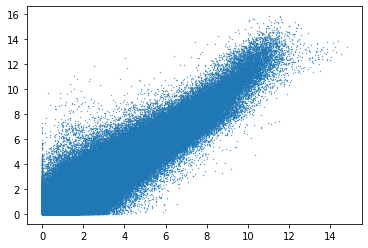

In [12]:
import matplotlib.pyplot as plt
plt.scatter(output_layer.asnumpy(), output_data.T.to_numpy(), s=0.1)
plt.show()

### get cell composition

In [13]:

import pandas as pd
cell_purity = hidden_lyer.asnumpy()
cell_purity = pd.DataFrame(cell_purity, columns=relation_data.columns, index=input_data.columns)

In [14]:
cell_purity.iloc[:3,:6]

cellName,1-cell stage cell (Blastomere),4-cell stage cell (Blastomere),8-cell stage cell (Blastomere),AXL+SIGLEC6+ dendritic cell,Abnormal plasma cell,Acinar cell
TCGA-J8-A3YE-01A,0.000000,0.000000,0.631689,0.004752,0.468052,0.0
TCGA-BJ-A28W-01A,0.408473,0.000000,0.701050,0.172757,0.265118,0.0
TCGA-EL-A4K9-01A,0.000000,0.095825,0.590744,0.000000,0.378153,0.0


## 5. Fine train net

In [15]:
from mxnet import nd, gluon
from DCNet.dcutils import splitProfile
from DCNet.dcutils import fineTrain

prepare train data

In [16]:
x, x_na = splitProfile(input_data, ix)
y, y_na = splitProfile(output_data, ox)
x = nd.array(x.T)
y = nd.array(y.T)

define train params

In [17]:
trainer_1= gluon.Trainer(new_net.collect_params('.*weight_first'), 'adam', {'learning_rate': 1e-6, 'wd': 0})
trainer_2 = gluon.Trainer(new_net.collect_params('dense.*'), 'adam', {'learning_rate': 1e-4, 'wd': 0})
# trainer = gluon.Trainer(new_net.collect_params(), 'sgd', {'learning_rate': 1e-1, 'wd': 0})
loss = gluon.loss.L2Loss()

fine train net

In [18]:
errors = fineTrain(new_net, (x, y, y_na), trainer_1, trainer_2, loss, epochs=200)

fine train epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.84it/s]


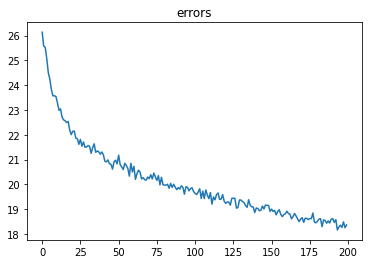

In [19]:
errors = pd.DataFrame(errors)
plt.plot(errors.iloc[:,1])
plt.title('errors')
plt.show()

In [20]:
output_y_fine = new_net.output
cell_purity_fine = new_net.first_layer

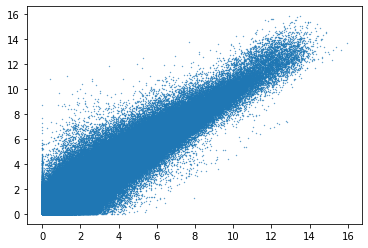

In [21]:
plt.scatter(output_y_fine.asnumpy(), output_data.T.to_numpy(), s=0.1)
plt.show()

# End!